main question:
- What's driving our target variable?
- get the big story
- SPLIT Data BEFORE Exploring (Comparing two variables)

## 1. Start with:

### A. Univariate stats:
- explore the target variable

### B. Then the bivariate stats:
- expore variable interactions
- scatterplot or lineplot
- numeric or categorical variables

### C. Then mulivariate:
- sns.pairplot

## 2. A. Stats tests to Use:
- num:num = pearson/spearman
- num:cat = t-test, ANOVA (for multiple), Mann-Whitney
- cat:cat = chi2

## B. Document:
- initial questions/assumptions
- takeaways after each viz
- your answers to each question
- your null/alt hypothesis, type of test, test results, your conclusion
- your takeaways
- action plan: new questions post takeaways, next steps

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split

np.random.seed(123)

In [2]:
import env

def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

def get_titanic():
    my_query="SELECT * FROM passengers"
    df = pd.read_sql(my_query, get_connection('titanic_db'))
    return df


In [3]:
df=get_titanic()
df.head()

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,None,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0
2,2,1,3,female,26.0,0,0,7.9250,S,Third,None,Southampton,1
3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0
4,4,0,3,male,35.0,0,0,8.0500,S,Third,None,Southampton,1


In [5]:
df.isna().sum()

passenger_id      0
survived          0
pclass            0
sex               0
age             177
sibsp             0
parch             0
fare              0
embarked          2
class             0
deck            688
embark_town       2
alone             0
dtype: int64

In [6]:
df.isna().mean()

passenger_id    0.000000
survived        0.000000
pclass          0.000000
sex             0.000000
age             0.198653
sibsp           0.000000
parch           0.000000
fare            0.000000
embarked        0.002245
class           0.000000
deck            0.772166
embark_town     0.002245
alone           0.000000
dtype: float64

- need to figure out how many nulls we have, and what to do with those columns

In [7]:
# drop rows where age or embarked is null, drop column 'deck', drop passenger_id
def prep_titanic(df):
    '''
    take in titanc dataframe, remove all rows where age or embarked is null, 
    get dummy variables for sex and embark_town, 
    and drop sex, deck, passenger_id, class, and embark_town. 
    '''

    df = df[(df.age.notna()) & (df.embarked.notna())]
    df = df.drop(columns=['deck', 'passenger_id', 'class'])

    dummy_df = pd.get_dummies(df[['sex', 'embark_town']], prefix=['sex', 'embark'])

    df = pd.concat([df, dummy_df.drop(columns=['sex_male'])], axis=1)

    df = df.drop(columns=['sex', 'embark_town']) 

    df = df.rename(columns={"sex_female": "is_female"})

    return df


In [8]:
def train_validate_test_split(df, target, seed=123):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, 
                                            random_state=seed, 
                                            stratify=df[target])
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       random_state=seed,
                                       stratify=train_validate[target])
    return train, validate, test


In [9]:
# Stratify with categorical target variables
train, validate, test = train_validate_test_split(df, target='survived')
train.shape, validate.shape, test.shape

((498, 13), (214, 13), (179, 13))

In [11]:
train.survived.mean(), validate.survived.mean(), test.survived.mean()

(0.38353413654618473, 0.38317757009345793, 0.3854748603351955)

In [12]:
# Once Data is cleaned, let's explore!

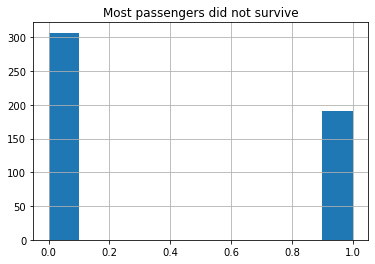

In [13]:
plt.title("Most passengers did not survive")
train.survived.hist()
plt.show()

In [14]:
# We can call .mean() since 0 and 1 are numeric
print("Percent survived from train")
round(train.survived.mean(), 3)

Percent survived from train


0.384

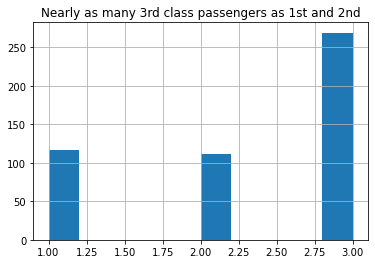

In [15]:
plt.title("Nearly as many 3rd class passengers as 1st and 2nd")
train.pclass.hist()
plt.show()

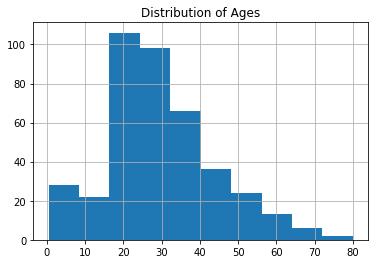

In [16]:
plt.title("Distribution of Ages")
train.age.hist()
plt.show()

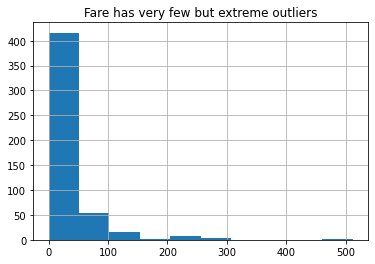

In [17]:
plt.title("Fare has very few but extreme outliers")
train.fare.hist()
plt.show()

## Takeaways & Actions

~60% perished and ~40% survived. Predicting "not survived" will be our baseline prediction to test the usefulness of features on later when we get to modeling. (With classification, a good baseline is the mode of the target)

Age seems close enough to a normal distribution

Fare has some extreme outliers and might still not be normally distributed after removing them. If that's the case, then we would run a Mann-Whitney test instead of a t-test. Use the p-value in the same manner.

Survived can be treated as either a categorical variable or a number. We can view survived via color on a chart, as categories on the x-axis on a bar chart, or as a proportion between 0 and 1 on the y-axis when viewing another categorical variable to compare "survival rate".

We can compare proportions of those who survived and those who didn't with another categorical variable. For example, we can test is female passengers were more or less likely to survive than male passengers using a chi-square test.

We can compare the mean of continuous variables between those who survived to those who did not survive using a test such as a t-test or Mann-Whitney test (the non-parametric version of the t-test). Such as, is there a difference in the average fare paid for those who survived vs. those who did not survive?

What else?

## Let's explore interactions of each variable with the target (Bivariate Stats)
We should analyze each feature with respect to the target variable. Document takewaways

A scatterplot will help us visualize numeric to numeric columns.

A catplot, barplot, or boxplot will help us visualize categorical variables with numeric variables. A nice thing about a .barplot is that by setting the binary target to the y axis, we see proportions.

Always write down what questions you have before you explore.

Always document your findings and takeaways, even if the takeaway is "There's nothing here between x and y"

Some findings from bi-variate exploration may need more detailed investigation with an additional variable...

In [18]:
train.head(2)


,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
583,583,0,1,male,36.0,0,0,40.125,C,First,A,Cherbourg,1
165,165,1,3,male,9.0,0,2,20.525,S,Third,None,Southampton,0


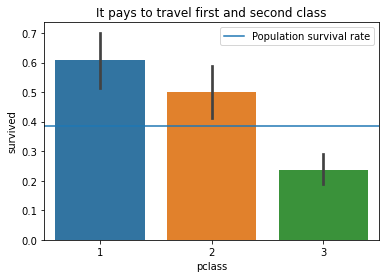

In [19]:
plt.title("It pays to travel first and second class")
sns.barplot(x="pclass", y="survived", data=train)
population_survival_rate = train.survived.mean()
plt.axhline(population_survival_rate, label="Population survival rate")
plt.legend()
plt.show()

In [20]:
# The above visual is quite clear, but if it was less clear or we want more certainty, we'll run a hypothesis test
# Let's run a chi squared to compare proportions, to have more confidence
alpha = 0.05
null_hypothesis = "survival and class of ticket are independent"
alternative_hypothesis = "there is a relationship between class of ticket and survival"

# Setup a crosstab of observed survival to pclass
observed = pd.crosstab(train.survived, train.pclass)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")

Reject the null hypothesis that survival and class of ticket are independent
Sufficient evidence to move forward understanding that there is a relationship between class of ticket and survival


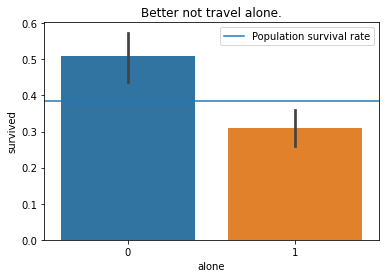

In [21]:
plt.title("Better not travel alone.")
sns.barplot(x="alone", y="survived", data=train)
population_survival_rate = train.survived.mean()
plt.axhline(population_survival_rate, label="Population survival rate")
plt.legend()
plt.show()

In [22]:
# If the visual was unclear or we need more confirmation, run a hypothesis test
# Let's run a chi squared to compare proportions
alpha = 0.05
null_hypothesis = "survival and traveling alone are independent"
alternative_hypothesis = "there is a relationship between survival and traveling alone"

# Setup a crosstab of observed survival to pclass
observed = pd.crosstab(train.survived, train.alone)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")


Reject the null hypothesis that survival and traveling alone are independent
Sufficient evidence to move forward understanding that there is a relationship between survival and traveling alone


ValueError: Could not interpret input 'is_female'

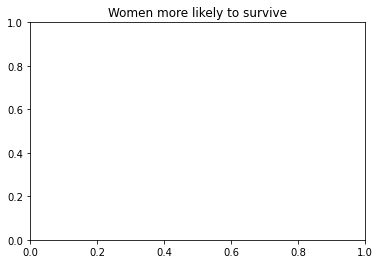

In [23]:
plt.title("Women more likely to survive")
sns.barplot(x="is_female", y="survived", data=train)
population_survival_rate = train.survived.mean()
plt.axhline(population_survival_rate, label="Population survival rate")
plt.legend()
plt.show()

In [ ]:
# Let's run a chi squared to compare proportions, to have more confidence
alpha = 0.05

null_hypothesis = "survival and gender are independent"
alternative_hypothesis = "there is a relationship between survival and gender"

# Setup a crosstab of observed survival to pclass
observed = pd.crosstab(train.survived, train.is_female)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")


## Comparing Numeric vs. a Categorical Example
If the visual is not completely clear, the need for a hypothesis test increases.

First, set your confidence level and your alpha (Confidence level of 95% and alpha of 0.05 are good)
Select the appropriate test for your 2 variables:
If numeric to numeric, run a correlation test
Compare proportions with 
χ
2
Compare means with t-test or Mann-Whitney u-test.
Run tests, form conclusions, and document your results
(rinse and then repeat with other variables of interest)

1 tailed Mann-Whitney test. For more on Mann-Whitney, see the Wikipedia article

Write down your hypothesis setup

H
0
: Survived passenger fares cost less than or equal to non-surviving passenger fare

H
a
: Surviving passenger fares cost more than non-surviving passenger fares

In [24]:
# Subset the data into survived and not-surviving status
not_survived = train[train.survived == 0]
survived = train[train.survived == 1]


In [25]:
# check variances of the two groups
not_survived.fare.var(), survived.fare.var()

(1147.9409071240707, 3687.77476607355)

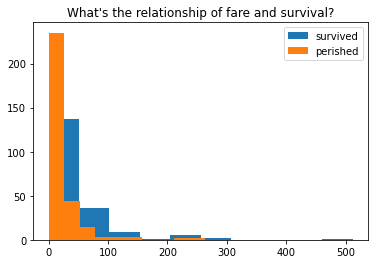

In [26]:
plt.title("What's the relationship of fare and survival?")
plt.hist(survived.fare, label="survived")
plt.hist(not_survived.fare, label="perished")
plt.legend()
plt.show()

In [30]:
from scipy import stats

null_hypothesis = "fares paid by survived passengers are less than or equal to fares paid by non-surviving passengers"
alternative_hypothesis = "fares paid by surviving passengers are higher than non-surviving passengers"

# Use Mann Whitney u-test when t-test assumptions do not hold.
# The distributions are not normal and the variances are not equal, so we'll do mann-whitney
t, p = stats.mannwhitneyu(survived.fare, not_survived.fare, alternative="greater")


In [31]:
if p < alpha:
    print("We find evidence to reject the null hypothesis that", null_hypothesis)
    print("We find evidence evidence to move forward with the understaind that", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("There is no evidence that", null_hypothesis)


We find evidence to reject the null hypothesis that fares paid by survived passengers are less than or equal to fares paid by non-surviving passengers
We find evidence evidence to move forward with the understaind that fares paid by surviving passengers are higher than non-surviving passengers


In [32]:
p

1.2105528373974754e-11

## Takeaways from bivariate exploration, so far
It pays to travel first and second class

Better to travel with family/company"

Women much more likely to survive

Survivors paid higher fares. This tracks with class of ticket.


## Multivariate Stats & Analysis
During this stage, we often add another dimension to our data, such as the target variable as color.

We also ask additional, more specific and targeted questions of the data, such as how subgroups compare to each-other and to the overall population. We then answer these questions using visualizations and/or hypothesis testing.

Some options for multivariate visuals: - If you have multiple numeric columns, generating a pairplot with the target variable set to the hue argument might help. It may also be too noisy. - A relplot of a numeric x, a numeric y, and a hue or col argument using a category z. If you discover a good set of numeric columns in the pairplot, then it would be valuable to create a visual for that pairing along with the target. - We can also use hue or col along with seaborn catplot - We can make subgroups based on multiple categorical features and compare to other groups or the population

Multivariate statistical tests exist, but are outside the scope of this course.

We can, however, create subgroups based on multiple categorical features and conduct hypothesis tests.

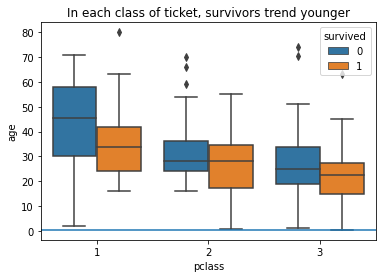

In [33]:
# At each class ticket, women have better survival rates
plt.title("In each class of ticket, survivors trend younger")
sns.boxplot(x="pclass", y="age", data=train, hue="survived")
population_survival_rate = train.survived.mean()
plt.axhline(population_survival_rate)
plt.show()

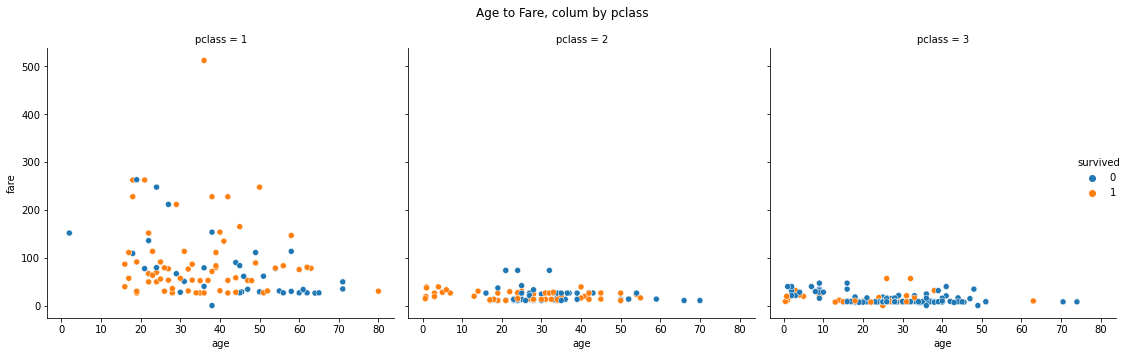

In [34]:
# No discernable relationship between age and fare, but the pclass relates to survival
rel = sns.relplot(x='age', y='fare', data=train, col="pclass", hue="survived")
rel.fig.suptitle('Age to Fare, colum by pclass') # One way to title a relplot
plt.tight_layout()


ValueError: Could not interpret input 'is_female'

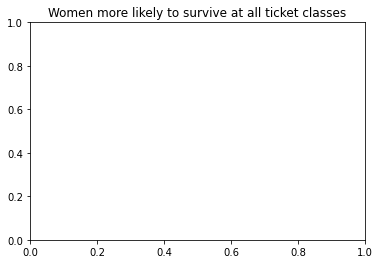

In [35]:
plt.title("Women more likely to survive at all ticket classes")
sns.barplot(x="pclass", y="survived", hue="is_female", data=train)
population_survival_rate = train.survived.mean()
plt.show()

In [ ]:
plt.title("Women more likely to survive at all ticket classes")
sns.barplot(x="pclass", y="survived", hue="is_female", data=train)
population_survival_rate = train.survived.mean()
plt.show()